In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import scipy.io as sio
import torch
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import LinearLR

from splice import splice_model
from splice.base import *
from splice.loadCellsFile import *
from splice.utilities import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing
The preprocessing code below is adapted from Carlos' notebook, with minor changes to variable names, using numpy instead of pandas, and slight optimizations

### Load the data

In [2]:
ratname = "A324"
sessdate = "2023_07_21"

session_info = mat2pyCellFileCleanup("../data/uberphys/%s_%s.mat" % (ratname, sessdate))
session_data = scipy.io.loadmat("../data/uberphys/%s_%s.mat" % (ratname, sessdate)) 

included_trials = np.argwhere((session_info["Trials"]['violated'] == 0) & ((~np.isnan(session_info["Trials"]["pokedR"])))).squeeze()
n_trials = included_trials.shape[0]
cpoke_in = session_info["Trials"]["stateTimes"]["cpoke_in"][included_trials]
cpoke_out = session_info["Trials"]["stateTimes"]["cpoke_out"][included_trials]

included_cells = np.argwhere(session_data['standard_inclusion_criteria'].squeeze()).squeeze()
brain_region = np.array(session_info['region'])[included_cells]

print(f"We have {n_trials} non-violation, valid trials")

No region found for cell 190, entering 'None'
No region found for cell 191, entering 'None'
No region found for cell 192, entering 'None'
No region found for cell 193, entering 'None'
No region found for cell 194, entering 'None'
No region found for cell 195, entering 'None'
No region found for cell 196, entering 'None'
No region found for cell 197, entering 'None'
No region found for cell 198, entering 'None'
No region found for cell 199, entering 'None'
No region found for cell 200, entering 'None'
No region found for cell 201, entering 'None'
No region found for cell 202, entering 'None'
No region found for cell 203, entering 'None'
No region found for cell 547, entering 'None'
No region found for cell 2202, entering 'None'
No region found for cell 2203, entering 'None'
No region found for cell 2204, entering 'None'
We have 714 non-violation, valid trials


### Bin and smooth firing rates
Here we bin spikes into 10 ms bins; then smooth with a 60ms sd Gaussian; then subsample down by 3.

We end up with **time_in_session**, a time in session vector, and **smoothed_rates**, an nCells x nTimebins matrix of smoothed firing rates (no trial structure yet)

In [3]:
spike_times= session_data['raw_spike_time_s'].squeeze()[included_cells]
n_cells = spike_times.shape[0]
print(f"We have {n_cells} cells total")

We have 2621 cells total


In [4]:
min_time = np.inf
max_time = -np.inf

for cell in spike_times:
    if len(cell) > 0:
        min_time = min(min_time, cell[0])
        max_time = max(max_time, cell[-1])

min_time = min_time[0] # type: ignore
max_time = max_time[0] # type: ignore
print(f"Min time: {min_time}, Max time: {max_time}")
    

Min time: 1658.66378, Max time: 14362.02429


In [5]:
dt = 0.01
bin_times = np.arange(np.floor(min_time), np.ceil(max_time), dt)
smooth_sigma = 0.06 # in seconds
subsample_factor = 3

filepath = f"../data/uberphys/%s_%s_%.3f_smoothed_rates.npz" % (ratname, sessdate, smooth_sigma)

if(os.path.exists(filepath)):
    data = np.load(filepath)
    smoothed_rates = data['smoothed_rates']
    time_in_session = data['time_in_session']
    print("Loaded smoothed rates from file")
else:
    time_in_session = bin_times[0:-1:subsample_factor]
    smoothed_rates = np.zeros((n_cells, len(time_in_session)))

    for cell in range(n_cells):
        if smooth_sigma == 0:
            smoothed_rates[cell] = binEvents(spike_times[cell], bin_times, dt)[0:-1:subsample_factor]/dt
        else:
            smoothed_rates[cell] = smoothIt(binEvents(spike_times[cell], bin_times, dt), smooth_sigma/dt)[0:-1:subsample_factor]/dt
        
        print(f"Done with {cell+1}/{n_cells} cells", end="\r")
    
    np.savez_compressed(filepath, smoothed_rates=smoothed_rates, time_in_session=time_in_session)

Loaded smoothed rates from file


### Put times into trials

We'll make a tensor **trial_rates**, nTrials x nCells x nTimebins, where nTimebins now just runs over `cpoke_in` to `cpoke_out`.

Note that different trials are different lengths.  We're timelocked to `cpoke_in`, but some will have `np.nan`s in their last timebins

In [6]:
trial_length = 0.5

trial_rates = np.zeros((n_trials, n_cells, int(np.ceil(trial_length/(dt*subsample_factor)))))
trial_times = list(np.arange(trial_rates.shape[-1])*(dt*subsample_factor))

for trial in range(n_trials):
    start = cpoke_in[trial]
    end = cpoke_out[trial]

    rates = smoothed_rates[:, (time_in_session >= start) & (time_in_session < end)]

    if rates.shape[1] > trial_rates.shape[-1]:
        add_length = rates.shape[1] - trial_rates.shape[-1]
        trial_rates = np.concatenate((trial_rates, np.nan * np.zeros((n_trials, n_cells, add_length))), axis=-1)

        new_times = list(trial_times[-1] + np.arange(1, (add_length+1))*(dt*subsample_factor))

        if new_times:
            trial_times.extend(new_times)
    
    trial_rates[trial, :, :rates.shape[1]] = rates

trial_times = np.array(trial_times)

## Autoencoder vs PCA

### Pick out cells from a brain region (Cg1)

In [7]:
np.unique(brain_region)

array(['ADS', 'CC', 'Cg1', 'DGd', 'DGv', 'DS', 'GP', 'M1', 'M2', 'MGB',
       'NAc', 'None', 'PrL', 'S1', 'SBN', 'TS'], dtype='<U4')

In [90]:
selected_region = "Cg1"
selected_cells = np.argwhere(brain_region == selected_region).squeeze()

selected_spike_times = spike_times[selected_cells]
selected_smoothed_rates = smoothed_rates[selected_cells]
n_cells_selected = selected_spike_times.shape[0]
print(f"We have {selected_spike_times.shape[0]} cells in {selected_region}")

We have 305 cells in Cg1


In [91]:
train_data.shape

(34043, 73)

In [100]:
train_data, test_data = train_test_split(trial_rates[:, selected_cells, :], test_size=0.15)

train_data = train_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
train_data = train_data[~np.isnan(train_data).any(axis=1)]

test_data = test_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
test_data = test_data[~np.isnan(test_data).any(axis=1)]

### Do PCA

In [101]:
pca = PCA(n_components=n_cells_selected)
pca.fit(train_data)

PCA(n_components=305)

In [102]:
s1 = np.var(test_data - train_data.mean(axis=0))
s2 = np.var(test_data)
test_var_explained = 1 - s1/s2
print(f"Variance explained by mean: {test_var_explained}")

Variance explained by mean: 0.4813761914665947


Text(0, 0.5, 'Cumulative Variance Explained')

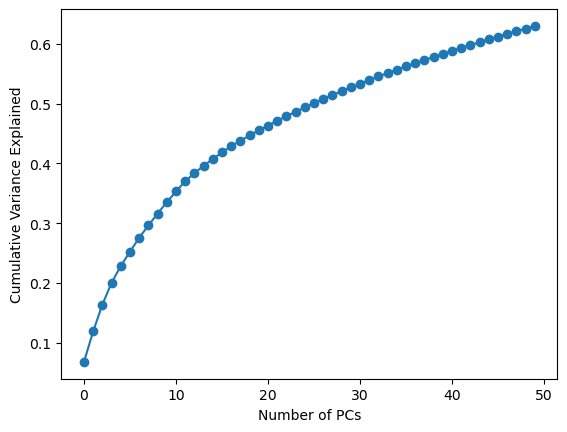

In [103]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:50], marker='o'); 
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative Variance Explained")

In [104]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

for dim in [2,3,5,10,20, 50]:
    test_pcs = pca.transform(test_data)
    test_pcs[:, dim:] = 0
    test_proj = pca.inverse_transform(test_pcs)

    s1 = np.var(test_data-test_proj)
    s2 = np.var(test_data - test_data.mean(axis=0))
    test_var_explained = 1 - s1/s2

    print(f"With {dim} PCs, we can explain {explained_variance[dim-1]:.4f} of the training variance and {test_var_explained:.4f} of the test variance. The MSE is {F.mse_loss(torch.Tensor(test_proj),torch.Tensor(test_data)):.4f}")

With 2 PCs, we can explain 0.1190 of the training variance and 0.1181 of the test variance. The MSE is 22.8693
With 3 PCs, we can explain 0.1639 of the training variance and 0.1575 of the test variance. The MSE is 21.8492
With 5 PCs, we can explain 0.2283 of the training variance and 0.2177 of the test variance. The MSE is 20.2880
With 10 PCs, we can explain 0.3349 of the training variance and 0.3252 of the test variance. The MSE is 17.4995
With 20 PCs, we can explain 0.4550 of the training variance and 0.4436 of the test variance. The MSE is 14.4298
With 50 PCs, we can explain 0.6297 of the training variance and 0.6124 of the test variance. The MSE is 10.0522


### Do Autoencoder

In [105]:
class Encoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Encoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.encoderLayers  = nn.ModuleList()
        self.nInputCells    = nInputCells

        for i in range(self.nLayers):
            if i == 0:
                self.encoderLayers.append(nn.Linear(self.nInputCells, nHiddensVector[i]))
            else:
                self.encoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.encoderLayers.append(nonlinearity)

        self.encoderLayers.append(nn.Linear(nHiddensVector[-1], bottleneckDim))

    def forward(self, x):
        for layer in self.encoderLayers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, bottleneckDim, nHiddensVector, nOutputCells,
                 nonlinearity = nn.ReLU()):
        super(Decoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.decoderLayers  = nn.ModuleList()
        self.nOutputCells   = nOutputCells

        for i in range(self.nLayers):
            if i == 0:
                self.decoderLayers.append(nn.Linear(bottleneckDim, nHiddensVector[i]))
            else:
                self.decoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.decoderLayers.append(nonlinearity)

        self.decoderLayers.append(nn.Linear(nHiddensVector[-1], nOutputCells))

    def forward(self, x):
        for layer in self.decoderLayers:
            x = layer(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(nInputCells, nHiddensVector, bottleneckDim, nonlinearity)
        self.decoder = Decoder(bottleneckDim, nHiddensVector[::-1], nInputCells, nonlinearity)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def trainAutoencoderWithValidation(model, data, nEpochs, learningRate, 
                                   lossFunction, optimizer, validationData,
                                   printEvery=100, verbose=True):

    for epoch in range(nEpochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = model(data)
        loss = lossFunction(output, data)
        loss.backward()
        optimizer.step()
        
        if verbose:
            if epoch % printEvery == 0:
                output = model(validationData)
                validationLoss = lossFunction(output, validationData)
                print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))            
    return model

In [110]:
model = Autoencoder(n_cells_selected, [100, 100, 50], 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunction = nn.MSELoss()

train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

trainAutoencoderWithValidation(model, train_data_tensor, 10000, 0.001, lossFunction, optimizer, test_data_tensor, printEvery=100)

Epoch 0, Loss: 68.081879, Validation loss: 68.555275
Epoch 100, Loss: 25.700527, Validation loss: 25.707458
Epoch 200, Loss: 25.651608, Validation loss: 25.654547
Epoch 300, Loss: 25.642099, Validation loss: 25.643810
Epoch 400, Loss: 25.566570, Validation loss: 25.551111
Epoch 500, Loss: 22.528486, Validation loss: 22.450006
Epoch 600, Loss: 20.428097, Validation loss: 20.676823
Epoch 700, Loss: 19.098831, Validation loss: 19.331100
Epoch 800, Loss: 18.624695, Validation loss: 18.955120
Epoch 900, Loss: 18.378736, Validation loss: 18.707161
Epoch 1000, Loss: 17.990992, Validation loss: 18.378487
Epoch 1100, Loss: 17.687544, Validation loss: 18.091293
Epoch 1200, Loss: 17.328756, Validation loss: 17.783316
Epoch 1300, Loss: 17.316446, Validation loss: 17.693060
Epoch 1400, Loss: 16.892323, Validation loss: 17.484331
Epoch 1500, Loss: 16.413065, Validation loss: 16.885447
Epoch 1600, Loss: 16.278246, Validation loss: 16.771645
Epoch 1700, Loss: 16.199982, Validation loss: 16.688881
Epoc

Autoencoder(
  (encoder): Encoder(
    (encoderLayers): ModuleList(
      (0): Linear(in_features=305, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=10, bias=True)
    )
  )
  (decoder): Decoder(
    (decoderLayers): ModuleList(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=305, bias=True)
    )
  )
)

In [112]:
def explainedVariance(data, model, train_data):
    mu = train_data.mean(axis=0).cpu().detach().numpy()
    return 1 - np.var((data - model(data)).cpu().detach().numpy())/np.var(data.cpu().detach().numpy()-mu)
# remainingVar = np.var((testData-model(testData)).cpu().detach().numpy())
# totalVar = np.var(testData.cpu().detach().numpy()-mu)
# fracExplainedVar = 1 - remainingVar/totalVar

bottleneckDim = 2

print("bottleneckDim=%d: frac test data variance explained: " % bottleneckDim, explainedVariance(test_data_tensor, model, train_data_tensor))
print("bottleneckDim=%d: frac train data variance explained: " % bottleneckDim, explainedVariance(train_data_tensor, model, train_data_tensor))

bottleneckDim=2: frac test data variance explained:  0.39313507080078125
bottleneckDim=2: frac train data variance explained:  0.4323834180831909


### Automate PCA-Autoencoder comparison

In [121]:
def compare_pca_ae(selected_region, brain_region, trial_rates, ae_dims=[2,3,5,10,20,50]):

    # select cells and trials
    selected_region = "DGd"
    selected_cells = np.argwhere(brain_region == selected_region).squeeze()
    n_cells_selected = selected_cells.shape[0]
    print(f"We have {selected_cells.shape[0]} cells in {selected_region}")

    train_data, test_data = train_test_split(trial_rates[:, selected_cells, :], test_size=0.15)

    train_data = train_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
    train_data = train_data[~np.isnan(train_data).any(axis=1)]

    test_data = test_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
    test_data = test_data[~np.isnan(test_data).any(axis=1)]

    # Do PCA
    pca = PCA(n_components=n_cells_selected)
    pca.fit(train_data)

    pca_var_explained = np.zeros(min(50, n_cells_selected))
    for dim in range(1,min(50, n_cells_selected)+1):
        test_pcs = pca.transform(test_data)
        test_pcs[:, dim:] = 0
        test_proj = pca.inverse_transform(test_pcs)

        s1 = np.var(test_data-test_proj)
        s2 = np.var(test_data - train_data.mean(axis=0))
        pca_var_explained[dim-1] = 1 - s1/s2

    # Do AE
    ae_var_explained = np.zeros(len(ae_dims))

    for i, dim in enumerate(ae_dims):
        #train 
        print(f"Training {dim}-dimensional autoencoder")
        model = Autoencoder(n_cells_selected, [100, 100, 50], dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        lossFunction = nn.MSELoss()

        train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
        test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

        trainAutoencoderWithValidation(model, train_data_tensor, 10000, 0.001, lossFunction, optimizer, test_data_tensor, printEvery=100, verbose=False)

        ae_var_explained[i] = explainedVariance(test_data_tensor, model, train_data_tensor)

    
    plt.title(f"Explained variance in {selected_region}")
    plt.plot(1,min(50, n_cells_selected)+1, pca_var_explained, label="PCA", marker='o')
    plt.plot(ae_dims, ae_var_explained, label="AE", marker='o')
    plt.legend()
    plt.xlabel("Number of dimensions")
    plt.ylabel("Explained variance")

    plt.savefig(f"../results/uberphys/pca_ae_comparison/{selected_region}_pca_ae.png")
    np.save(f"../results/uberphys/pca_ae_comparison/{selected_region}_pca_ae.npy", (pca_var_explained, ae_var_explained, ae_dims))

    return pca_var_explained, ae_var_explained
    

In [122]:
pcave, aeve = compare_pca_ae(selected_region, brain_region, trial_rates)

We have 73 cells in DGd
Training 2-dimensional autoencoder
Training 3-dimensional autoencoder
Training 5-dimensional autoencoder
